In [1]:
# Kristina Fauss
# April 19, 2024
# model selection by AIC testing all 1st order interactions

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.formula.api as smf

from ols_mixedef_custom import *

In [2]:
fp = '/Users/kristinafauss/BackupToBox/Git/lab-flammability-testing-2022/data/processed-data/main_dataset.csv'

flamog = pd.read_csv(fp)

# drop na's for flam metrics
print(len(flamog))
for col in ['fh', 'fd', 'pfg', 'temp_change', 'heat_flux_change']:
    flamog.dropna(subset=col, inplace=True)
print(len(flamog))

flamog['plant_id']=[str(a)+'_'+str(b) for a,b in zip(flamog['plant'], flamog['species'])]

# report
print(flamog.columns)
flamog.head()

172
171
Index(['Unnamed: 0', 'species', 'plant', 'date', 'total_branch_mass',
       'total_leaf_mass', 'stem_mass_ratio', 'leaf_mass_ratio', 'leaf_lfm',
       'thickness', 'leaf_wet_mass', 'leaf_dry_mass', 'stem_lfm', 'stem_width',
       'stem_wet_mass', 'stem_dry_mass', 'stem_sav', 'lfm', 'leaf_dmc',
       'stem_dmc', 'dmc', 'leaf_area', 'leaf_sav', 'LMA', 'SLA', 'rep',
       'branch_length', 'branch_width', 'branch_height', 'sample_wt',
       'no_branches', 'mpa', 'notes_on_plant_char', 'start_time',
       'ambient_temp', 'ambient_humidity', 'pre_ignition_glow',
       'first_glow_time', 'ignition', 'primary_ignition',
       'primary_time_of_flame_end', 'secondary_ignition',
       'secondary_time_of_flame_end', 'third_ignition',
       'third_time_of_ignition_flame_end', 'time_fh', 'fh', 'time_of_glow_end',
       'end_time', 'thermocoupler_height', 'hotplate_height',
       'notes_on_flam_data', 'fd', 'tti', 'pfg', 'max_temp',
       'time_at_max_temp', 'max_temp_sensor', '

,Unnamed: 0,species,plant,date,total_branch_mass,total_leaf_mass,stem_mass_ratio,leaf_mass_ratio,leaf_lfm,thickness,...,wet_mass,dry_mass,gdw_gfw,dw_flam_sample,ww_flam_sample,branch_volume,branching,sample_density,dw_sppdev,plant_id
0,1,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.291195,4.035205,1082.04,0.416667,0.004923,0.923122,1_ARCDEN
1,2,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.429372,4.467028,1370.20,0.322581,0.004303,1.348152,1_ARCDEN
2,3,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,682.04,0.294118,0.007766,0.900752,1_ARCDEN
3,4,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,1.283923,4.012477,1262.25,0.466667,0.004196,0.900752,1_ARCDEN
4,5,ARCDEN,1,2022-08-10,20.347,19.505,0.510564,0.489436,251.06912,0.514,...,1.151,0.3683,0.242414,0.811215,2.535185,819.00,0.500000,0.004086,-0.553297,1_ARCDEN


# Examine Correlation & Structure in Num. Var's

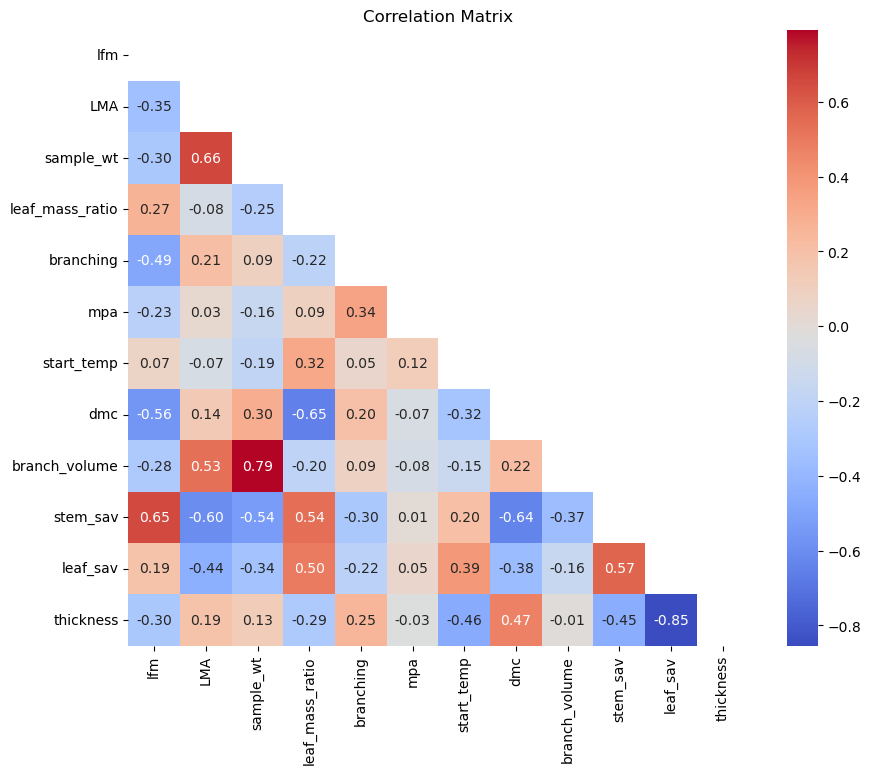

In [3]:
cols_num_use = ['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness']

corrplot(flamog, cols_num_use)

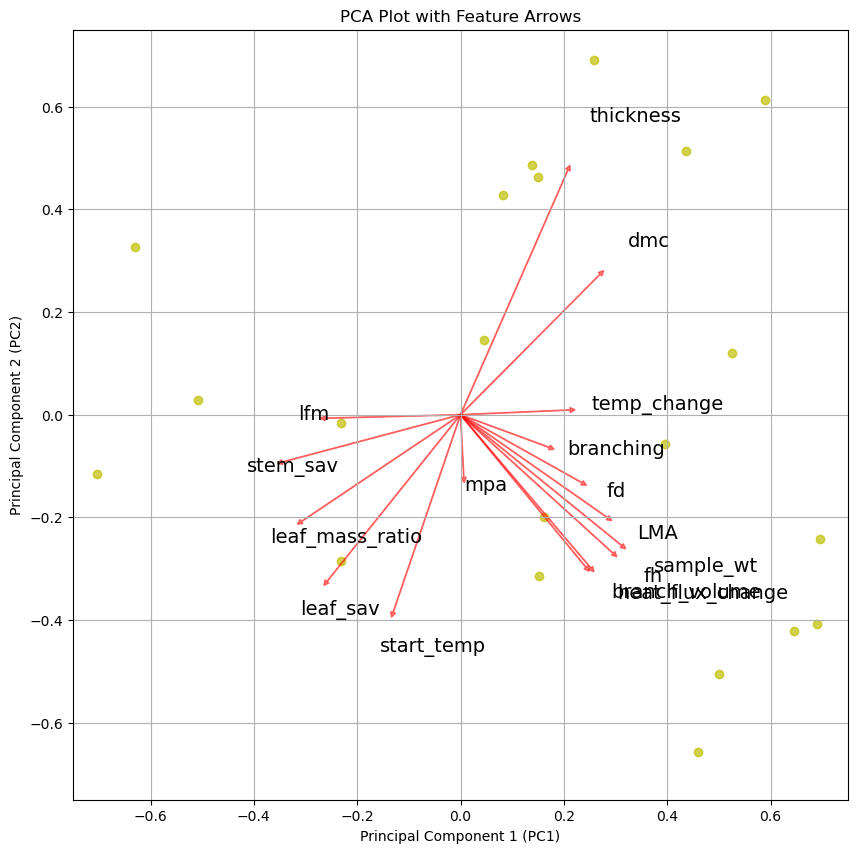

In [4]:
PCAplot(flamog, cols_num_use+['fh','fd','temp_change','heat_flux_change'])

# Modeling Preprocessing

In [5]:
# scale and center
cols_all = ['fh', 'fd', 'temp_change', 'heat_flux_change'] + cols_num_use
flam = scale_and_center(flamog, cols_all, cols_no_change=['plant_id', 'species', 'ignition'])

# declare as factors
flam['species'] = pd.Categorical(flam['species'])
flam['plant_id'] = pd.Categorical(flam['plant_id'])
flam['ignition'] = pd.Categorical(flam['ignition'])

# drop na's
print(len(flam))
cols_all_dpna = cols_all + ['plant_id', 'species', 'ignition']
flam.dropna(subset=cols_all_dpna, inplace=True)
print(len(flam))

# declare all possible IV cols to model
cols_use = cols_num_use + ['species']
print(cols_use)

167
162
['lfm', 'LMA', 'sample_wt', 'leaf_mass_ratio', 'branching', 'mpa', 'start_temp', 'dmc', 'branch_volume', 'stem_sav', 'leaf_sav', 'thickness', 'species']


# Run Model Selector

### NOTE: Random effect is simply `plant_id`
- NO nested effects
- NO `species'

#### It was not possible to test all combinations. Therefore, only combinations of significnt interaction terms and all singletons will be tested.

In [6]:
mxs = 11 #5
mns = 1
mxi = 2 #5
mni = 2

# Flame Height

In [7]:
AIC_iterator(flam, cols_use, Y_VAR='fh',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

ERROR: Formula model error: fh ~ leaf_sav*thickness

Columns present in sig. interaction terms: {'thickness', 'mpa', 'branch_volume', 'branching', 'leaf_mass_ratio', 'start_temp', 'lfm', 'LMA', 'leaf_sav', 'sample_wt', 'species', 'dmc'}

Total Num. Cols : Num. Sig. Int. Cols;  13 : 12

Significant Interactions:
('lfm', 'dmc')
('lfm', 'branch_volume')
('lfm', 'leaf_sav')
('lfm', 'thickness')
('LMA', 'dmc')
('LMA', 'species')
('sample_wt', 'species')
('leaf_mass_ratio', 'dmc')
('leaf_mass_ratio', 'leaf_sav')
('leaf_mass_ratio', 'thickness')
('branching', 'dmc')
('branching', 'leaf_sav')
('branching', 'thickness')
('branching', 'species')
('mpa', 'branch_volume')
('mpa', 'species')
('start_temp', 'dmc')
('start_temp', 'species')
('dmc', 'branch_volume')
('dmc', 'leaf_sav')
('dmc', 'thickness')
('leaf_sav', 'species')
('thickness', 'species')

Number of formulas: 175616


KeyboardInterrupt: 

# Flame Duration

In [ ]:
AIC_iterator(flam, cols_use, Y_VAR='fd',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Temp Change

In [ ]:
AIC_iterator(flam, cols_use, Y_VAR='temp_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)

# Heat Flux Change

In [ ]:
AIC_iterator(flam, cols_use, Y_VAR='temp_change',
            minnumsingle=mns, maxnumsingle=mxs, minnumint=mni, maxnumint=mxi)